In [52]:
import numpy as np
from pathlib import Path

from pymor.basic import *
from pymor.core.pickle import load

from RBInvParam.problems.problems import build_InstationaryModelIP

set_log_levels({
    'pymor' : 'WARN'
})

set_defaults({})

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'figure.dpi': 400
})

In [54]:
#WORK_DIR = Path('/run/media/benedikt/38E84473425D444F/Dokumente/Studium/Mathematik/PhD/parabolische_inverse_probleme')
WORK_DIR = Path('/home/benedikt/Dokumente/parabolische_inverse_probleme')

SAVE_PATH = Path('/home/benedikt/Dokumente/Paper/parabolische_inverse_probleme/figures/experiments')

method = 'TR_IRGNM'
dump_path = WORK_DIR / Path('experiments/test_enrichment_strategy_new') / f'reaction_TR_non_time_dep_1e-12'

setup_path = dump_path / 'setup.pkl'
optimizer_parameter_path = dump_path / 'optimizer_parameter.pkl'
data_path = dump_path / f'{method}_final.pkl'
final_data_path = dump_path / f'{method}_final.pkl'

with open(setup_path, 'rb') as file:
    setup = load(file)

with open(optimizer_parameter_path, 'rb') as file:
    optimizer_parameter = load(file)

if not 'FOM' in locals():
    FOM, grid_data, _ = build_InstationaryModelIP(setup=setup)

q_exact = setup['model_parameter']['q_exact']

with open(data_path, 'rb') as file:
    data = load(file)


if final_data_path.exists():
    with open(final_data_path, 'rb') as file:
        final_data = load(file)

In [55]:
len(data['reduced_bases']['parameter_basis'])

7

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

/tmp/ipykernel_11576/1896460656.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


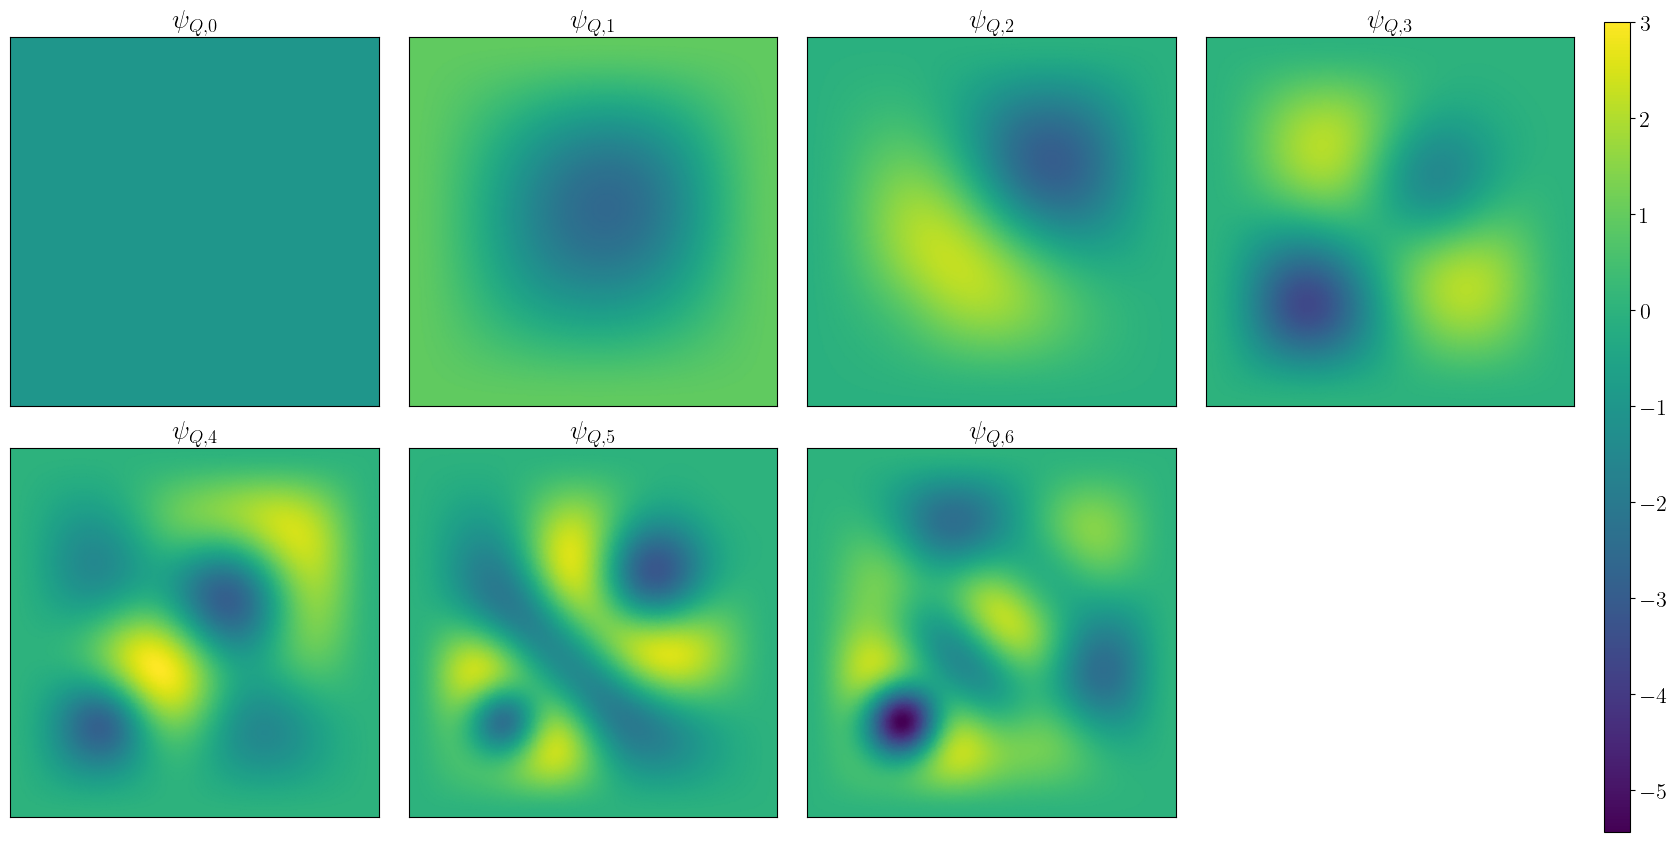

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import gridspec

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 16,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{accents} \usepackage{mathrsfs} \usepackage{bm}',
    'figure.dpi': 100
})

def plot_q_diffs(data, ax, vmin, vmax):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])    
    return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# Get global color scale limits
n_Q = len(data['reduced_bases']['parameter_basis'])
all_data = [data['reduced_bases']['parameter_basis'][i].to_numpy()[0] for i in range(n_Q)]
vmin = min(np.min(d) for d in all_data)
vmax = max(np.max(d) for d in all_data)
    
# Bigger figure to improve plot sizes
fig = plt.figure(figsize=(18, 9))

# Use GridSpec with minimal spacing and small colorbar width
gs = gridspec.GridSpec(2, 5, width_ratios=[1]*4 + [0.07], wspace=0.10, hspace=0.03)

# Plotting
axes = []
for i in range(n_Q):
    row = i // 4
    col = i % 4
    ax = fig.add_subplot(gs[row, col])
    c = plot_q_diffs(data['reduced_bases']['parameter_basis'][i], ax, vmin, vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_title(r'$\varpsi_{' + str(i) + r', Q}$', pad=7)
    ax.set_title(r'$\psi_{Q, ' + str(i) + r'}$', pad=7)
    axes.append(ax)

# Colorbar (occupies the last column, right edge, vertically centered)
cbar_ax = fig.add_subplot(gs[:, -1])
fig.colorbar(c, cax=cbar_ax)

# Adjust margins to bring colorbar closer and plots larger
fig.subplots_adjust(left=0.04, right=0.94, top=0.95, bottom=0.05)
fig.tight_layout()
#fig.show()
fig.savefig(SAVE_PATH / Path('./run_1_q_basis.pdf'), bbox_inches='tight')


/tmp/ipykernel_11576/3306995639.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/benedikt/Dokumente/parabolische_inverse_probleme/venv_39/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/benedikt/Dokumente/parabolische_inverse_probleme/venv_39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


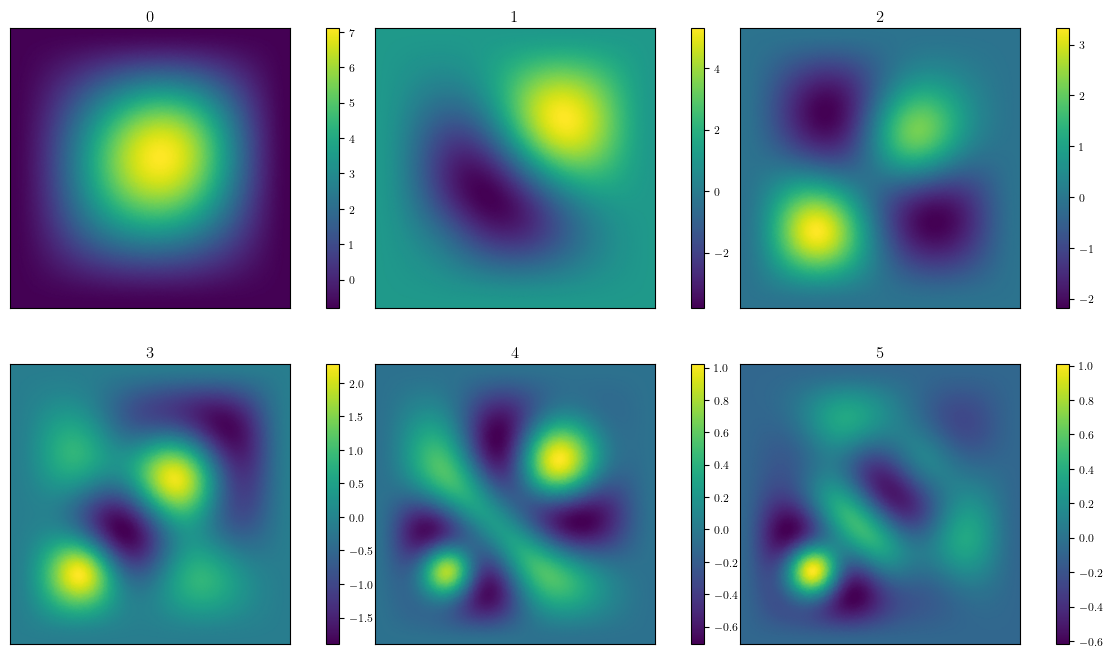

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import gridspec

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'figure.dpi': 100
})

def plot_q_diffs(data, ax, vmin=None, vmax=None):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])    
    return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# Figure and GridSpec with narrow colorbar columns
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.04]*3, wspace=0.06)

for i in range(6):
    row = i // 3
    col_plot = (i % 3) * 2
    col_cbar = col_plot + 1

    # Plot axis
    ax = fig.add_subplot(gs[row, col_plot])
    diff = data['q'][i+1] - data['q'][i]
    c = plot_q_diffs(diff, ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'{i}', pad=5)

    # Narrow colorbar axis
    cbar_ax = fig.add_subplot(gs[row, col_cbar])
    fig.colorbar(c, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=8)

#fig.subplots_adjust(left=0.03, right=0.97, top=0.95, bottom=0.08)
fig.show()
#fig.savefig(SAVE_PATH / Path('./run_1_q_diffs.pdf'), bbox_inches='tight')


/tmp/ipykernel_11576/467429355.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_11576/467429355.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


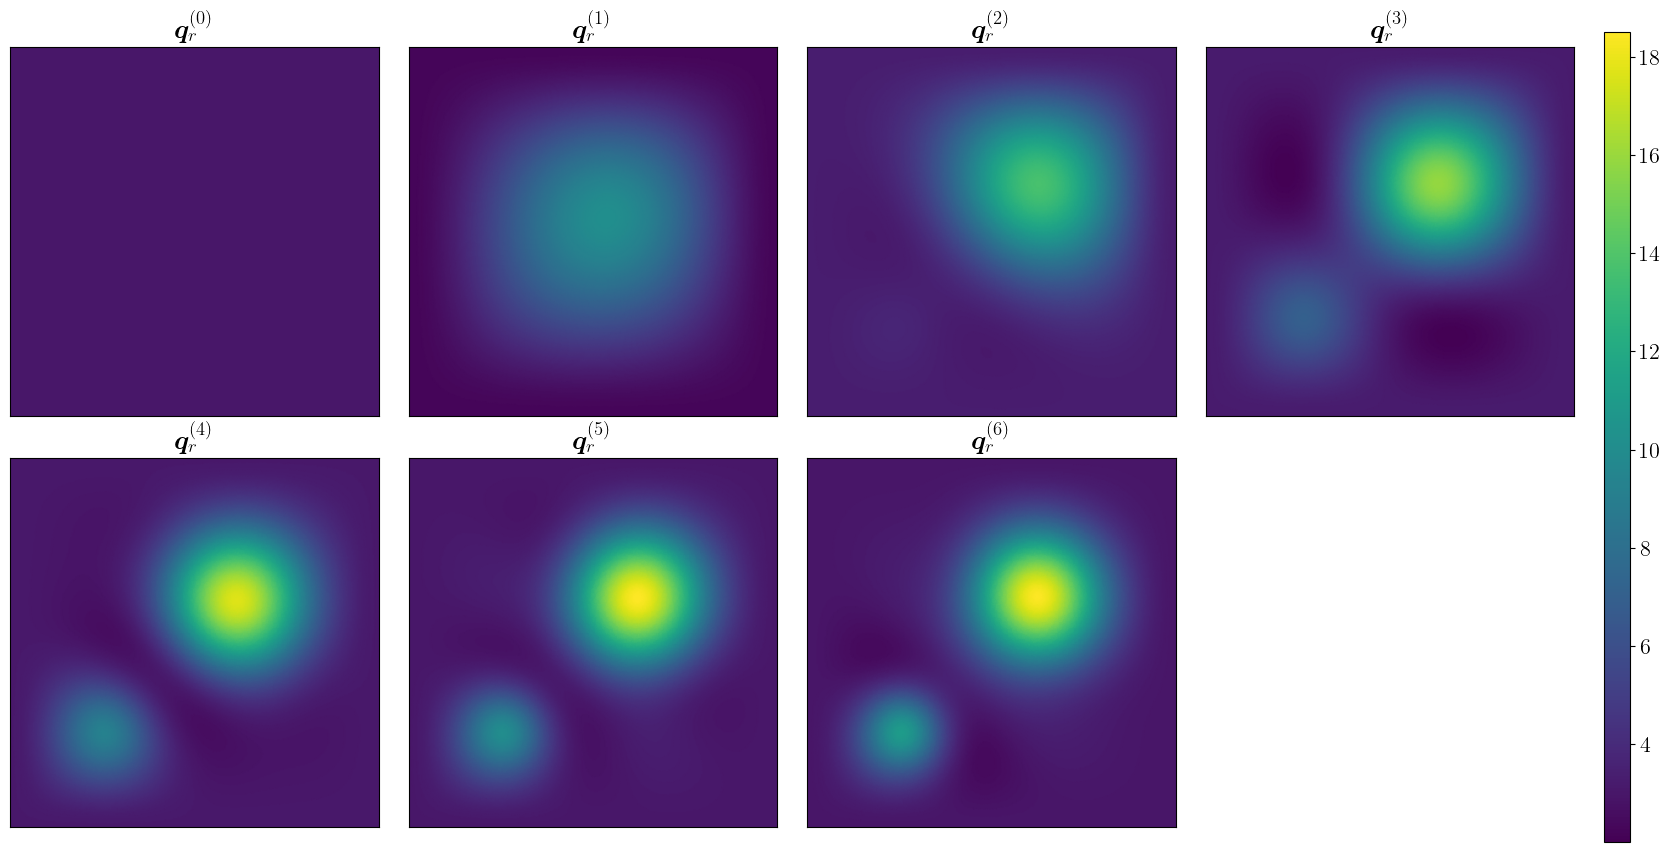

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import gridspec

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 16,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{accents} \usepackage{mathrsfs} \usepackage{bm}',
    'figure.dpi': 100
})

def plot_q_diffs(data, ax, vmin=None, vmax=None):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])    
    return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# Get global color scale limits
n_iter = len(data['q'])
all_data = [data['q'][i].to_numpy() for i in range(n_iter)]
vmin = min(np.min(d) for d in all_data)
vmax = max(np.max(d) for d in all_data)
    
# Bigger figure to improve plot sizes
fig = plt.figure(figsize=(18, 9))

# Use GridSpec with minimal spacing and small colorbar width
gs = gridspec.GridSpec(2, 5, width_ratios=[1]*4 + [0.07], wspace=0.10, hspace=0.03)

# Plotting
axes = []
for i in range(n_iter):
    row = i // 4
    col = i % 4
    ax = fig.add_subplot(gs[row, col])
    c = plot_q_diffs(data['q'][i], ax, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(r'$\bm{q}^{(' + str(i) + r')}_r$', pad=7)
    axes.append(ax)

# Colorbar (occupies the last column, right edge, vertically centered)
cbar_ax = fig.add_subplot(gs[:, -1])
fig.colorbar(c, cax=cbar_ax)

# Adjust margins to bring colorbar closer and plots larger
fig.subplots_adjust(left=0.04, right=0.94, top=0.95, bottom=0.05)
fig.tight_layout()
fig.show()
fig.savefig(SAVE_PATH / Path('./run_1_qs.pdf'), bbox_inches='tight')
